In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.signal import lfilter, firls, decimate
from tqdm import tqdm_notebook as tqdm
from easydict import EasyDict as edict
from collections import Counter
import pickle

In [3]:
resDir = Path("../results")
dataDir = Path("../data")

filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

In [4]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

num = fMRIs.shape[-1]
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

## Select the kappa with logistic regression

In [5]:
saveDir = resDir/"fMRIHPFs_logReg"
if not saveDir.exists():
    saveDir.mkdir()

    
Lmin = 4
lamb = 8e-5
kappas = np.arange(1, 4, 0.01)

numChgsAll = []
DetObjs = []
for ii in tqdm(range(243)):
    Ymat = fMRIsHPF[ii]
    DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=20, is_detrend=False,
                      saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=2, r=None)
    DetRec()
    DetRec.TuningKappa(kappas)
    
    DetObjs.append(DetRec)
    numChgsAll.append(DetRec.numchgs)
    

Text(0, 0.5, 'AUC')

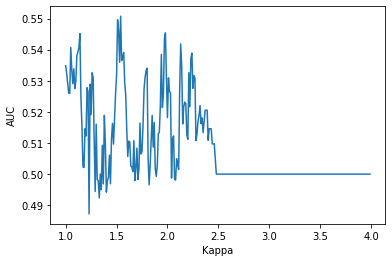

In [42]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import metrics

Ys = np.concatenate([np.ones(103), np.zeros(140)])
numChgsArr = np.array(numChgsAll)

aucs = []
for i in range(numChgsArr.shape[1]):
    curNumChgs = numChgsArr[:, i].reshape(-1, 1)
    clf = LogReg(solver='lbfgs').fit(curNumChgs, Ys)
    pred_probs = clf.predict_proba(curNumChgs)[:, 1]
    fpr, tpr, thres = metrics.roc_curve(Ys, pred_probs)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    
plt.plot(kappas, aucs) 
plt.xlabel("Kappa")
plt.ylabel("AUC")

In [46]:
#optKa = kappas[np.argmax(aucs)]
## Update det obj
#errs = []
#for DetObj in DetObjs:
#    DetObj.UpdateEcpts(DetObj.numchgs[kappas==optKa][0])
#
#result = edict()
#result.DetObjs = DetObjs
#result.kappa = optKa
#
#with open(saveDir/"fMRIResultAdapLogReg.pkl", "wb") as f:
#    pickle.dump(result, f)
    
with open(saveDir/"fMRIResultAdapLogReg.pkl", "rb") as f:
    result = pickle.load(f)
    
optKa = result.kappa
DetObjs = result.DetObjs

Text(0.5, 0, 'Ranks')

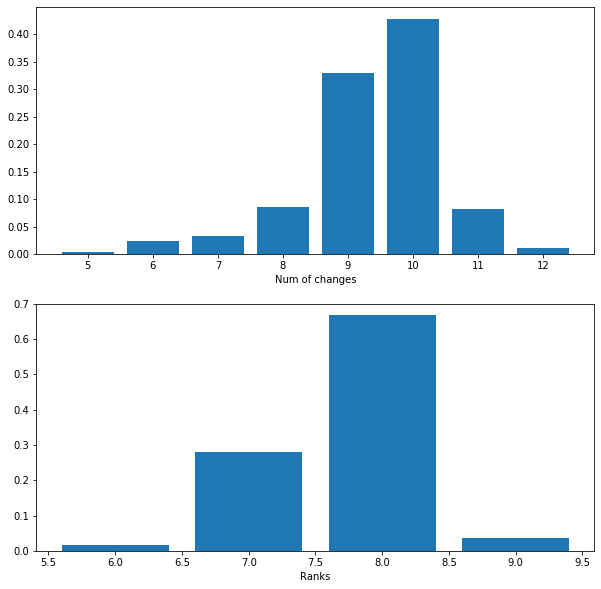

In [47]:
DetObjs = result.DetObjs
numchgs = []
nRanks = []
for DetObj in DetObjs:
    numchgs.append(len(DetObj.ecpts))
    nRanks.append(DetObj.paras.r)

numchgsCT = Counter(numchgs)
rankCT = Counter(nRanks)

keys = sorted(numchgsCT.keys())
ct = [numchgsCT[key] for key in keys]
rKeys = sorted(rankCT.keys())
rCt = [rankCT[key] for key in rKeys]

plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.bar(keys, np.array(ct)/len(DetObjs))
plt.xlabel("Num of changes")

plt.subplot(212)
plt.bar(rKeys, np.array(rCt)/len(DetObjs))
plt.xlabel("Ranks")

In [50]:
Adics = []
for DetObj in result.DetObjs:
    cDic = {}
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    cDic["eigVals"] = DetObj.RecResCur.LamMs
    cDic["Us"] = rUs
    Adics.append(cDic) 
with open(saveDir/"all_logreg_eigvals_vecs.pkl", "wb") as f:
    pickle.dump(Adics, f)